 Dimensione d  Entropia Media (Caotiche)  Entropia Media (Regolari)
            2                   1.993304                   1.025695
            3                   2.983325                   1.158146
            4                   3.972738                   1.205701
            5                   4.961694                   1.225707
            6                   5.950271                   1.225707
            7                   6.938458                   1.225707
            8                   7.925975                   1.225707
            9                   8.912540                   1.225707
           10                   9.897145                   1.225707
           11                  10.878075                   1.225707
           12                  11.851584                   1.225707
           13                  12.809920                   1.225707
           14                  13.736463                   1.225707
           15                  14.591884        

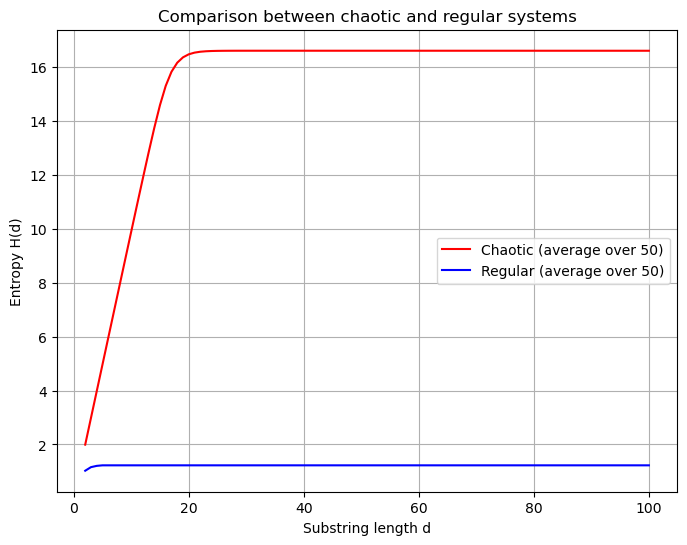

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from collections import Counter
import pandas as pd


N = 100000 
min_dim = 2
max_dim = 100

def is_perfect_square(n):
    """ Checks whether an integer is a perfect square. """
    return n >= 0 and int(np.sqrt(n)) ** 2 == n

# Generation of the 10 chaotic maps
def generate_chaotic_maps(n=10):
    chaotic_maps = []
    
    while len(chaotic_maps) < n:
        a, b, c, d = np.random.randint(-5, 6, size=4)  # Matrix with values between -5 and 5
        
        if a * d - b * c != 1:  # Constraint on the determinant
            continue
        
        trace = a + d  # Calculating the trace
        discriminant = trace**2 - 4  # Discriminant of eigenvalue formula
        
        # Make sure that the discriminant is NOT a perfect square (for irrational eigenvalues)
        if is_perfect_square(discriminant):
            continue
        
        eigenvalues = np.linalg.eigvals([[a, b], [c, d]])  # Calculating eigenvalues
        
        # Check that the eigenvalues satisfy the hyperbolicity condition
        if max(eigenvalues) > 1 and min(eigenvalues) < 1:
            chaotic_maps.append((a, b, c, d))

    return chaotic_maps

# Generation of the 10 regular maps
def generate_regular_maps(n=10):
    regular_maps = []
    
    while len(regular_maps) < n:
        a, b, c, d = np.random.randint(-5, 6, size=4)   # Matrix with values between -5 and 5
        
        det_T = a * d - b * c  # Calculating the determinant
        if det_T not in [-1, 1]:  # The transformation must be invertible and conservative
            continue

        trace = a + d  # Calculating the trace
        discriminant = trace**2 - 4 * det_T  # Discriminant of the characteristic polynomial

        # If the discriminant is negative, the eigenvalues are complex
        if discriminant >= 0:
            continue

        eigenvalues = np.linalg.eigvals([[a, b], [c, d]])  # Calculating eigenvalues
        
        # Check that the eigenvalues have modulus ≈ 1 to ensure that there is no exponential growth
        if (
            np.allclose(np.abs(eigenvalues), 1, atol=1e-20)  # Module ≈ 1
            and np.all(np.abs(eigenvalues - 1) > 0.05)  # Avoid λ ≈ 1 (almost chaotic)
            and np.all(np.abs(eigenvalues + 1) > 0.05)  # Avoid λ ≈ -1 (almost chaotic)
        ):
            regular_maps.append((a, b, c, d))

    return regular_maps


def arnold_cat_map_DATA(N, Cat):
    string = np.zeros(N, dtype=int)
    a, b, c, d = Cat
    x0, y0 = 0.1, 0.1 

    for i in range(N):
        x = (a * x0 + b * y0) % 1
        y = (c * x0 + d * y0) % 1
        string[i] = 1 if (0 <= x <= 0.5 and 0.5 <= y <= 1) or (0.5 <= x <= 1 and 0 <= y <= 0.5) else 0
        x0, y0 = x, y  

    return string


def get_substring_frequencies(binary_list, d):
    counter = Counter()
    total_windows = N - d + 1
    
    for i in range(total_windows):
        pattern = tuple(binary_list[i : i + d])
        counter[pattern] += 1
    
    return counter, total_windows


def compute_entropy(counter, total_windows):
    H = 0.0
    for pattern, count in counter.items():
        p = count / total_windows
        H -= p * math.log2(p)
    return H


def compute_entropies_for_dims(binary_list, min_dim, max_dim):
    dims = []
    entropies = []
    
    for d in range(min_dim, max_dim + 1):
        counter, total_windows = get_substring_frequencies(binary_list, d)
        H = compute_entropy(counter, total_windows)
        dims.append(d)
        entropies.append(H)
    
    return dims, entropies

# Generation of the 50 chaotic and regular maps
chaotic_matrices = generate_chaotic_maps(50)
regular_matrices = generate_regular_maps(50)

# Generation of binary sequences for each map
chaotic_sequences = [arnold_cat_map_DATA(N, Cat) for Cat in chaotic_matrices]
regular_sequences = [arnold_cat_map_DATA(N, Cat) for Cat in regular_matrices]

# Calculation of average entropies for chaotic and regular
chaotic_entropies = np.zeros(max_dim - min_dim + 1)
regular_entropies = np.zeros(max_dim - min_dim + 1)

for seq in chaotic_sequences:
    dims, entropies = compute_entropies_for_dims(seq, min_dim, max_dim)
    chaotic_entropies += np.array(entropies)

for seq in regular_sequences:
    dims, entropies = compute_entropies_for_dims(seq, min_dim, max_dim)
    regular_entropies += np.array(entropies)

# Average over 50 maps
chaotic_entropies /= 50
regular_entropies /= 50

# Dataframe
df_summary = pd.DataFrame({
    "Dimensione d": dims,
    "Entropia Media (Caotiche)": chaotic_entropies,
    "Entropia Media (Regolari)": regular_entropies
})

print(df_summary.to_string(index=False))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(dims, chaotic_entropies, label="Chaotic (average over 50)", color="red")
plt.plot(dims, regular_entropies, label="Regular (average over 50)", color="blue")
plt.xlabel("Substring length d")
plt.ylabel("Entropy H(d)")
plt.title("Comparison between chaotic and regular systems")
plt.legend()
plt.grid()
plt.show()

